### Machine Learning Part 
>**Problem Statement**: How different factors affect the rating of an anime?

>**Predictors**: Genres, Studio, Period of Release

>**Response**: Rating

    Model Used: 
    1. Logistic Regression
    2. Decision Tree
    3. Random Forest
    4. Nearest Neighbour
    5. MLPClassifier (Neural Network)

In [1]:
#Import of necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

#Sklearn libraries
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#k-fold cross validation
from sklearn.model_selection import KFold, cross_val_score, cross_validate 

from sklearn.tree import plot_tree # Plot the trained Decision Tree
#Metrics for evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, plot_confusion_matrix

### Loading Dataset and Data Preparation

In [2]:
filteredanime_data = pd.read_csv("filtered-anime-data.csv")
filteredanime_data.head()
#Further cleaning - some tags have two consecutive commas
filteredanime_data["Tags"] = filteredanime_data.Tags.str.replace(",,", ",")
#Reindex
filteredanime_data= filteredanime_data.reset_index(drop = True) 
#Studio is Category
filteredanime_data["Studio"] = filteredanime_data["Studio"].astype('category')
filteredanime_data["Release_year"] = filteredanime_data["Release_year"].astype('int')

In [3]:
#Get the top 15 studios - there are 493 different studios
studios = filteredanime_data["Studio"].value_counts()
top_15_studios = studios.head(15)
top_15_studios = list(top_15_studios.to_dict())
top_15_studios

#Only keep top 15 studios - we are left with 2650 entries
filteredanime_data = filteredanime_data.loc[filteredanime_data["Studio"].isin(top_15_studios)]
len(filteredanime_data)

2650

In [4]:
#Similarly, for genre, we keep only the top 15 genres - there are 522 different genres
genres = filteredanime_data.Tags.str.split(', ',expand=True).stack().value_counts()
top_15_genres = genres.head(15)
print(top_15_genres)
top_15_genres = top_15_genres.to_dict()
top_15_genres = list(top_15_genres.keys())

Based on a Manga          1040
Action                     888
Comedy                     744
Sci Fi                     682
Shounen                    647
Fantasy                    559
Adventure                  525
Family Friendly            474
Original Work              411
Drama                      396
Non-Human Protagonists     305
Magic                      260
Romance                    251
School Life                247
Mecha                      246
dtype: int64


In [5]:
#Label based on one of the five rating category
ratings = ["Poor (1.76, 3.34]", "Average (3.34, 3.53]", "Good (3.53, 3.7775]", "Excellent (3.7775, 4.6]"]
#Split into 4 equal parts - to ensure there is minimal class imbalance
filteredanime_data["Rating Category"], rating_bins = pd.qcut(x = filteredanime_data.Rating, q = 4, labels = ratings, retbins=True)
print(rating_bins)

#Label based on one of the five period category
periods = ["Before 1990", "1990 - 2002", "2003 - 2009", "2010 - 2015", "After 2015"]
#Split into 5 equal parts - to ensure there is minimal class imbalance
filteredanime_data["Period"], period_bins = pd.qcut(x = filteredanime_data.Release_year, q = 5, labels = periods, retbins = True)
print(period_bins)
    
#Convert the string in Tags into a list for Multi Label Binarizer
filteredanime_data["Tags"] = filteredanime_data["Tags"].str.split(", ").tolist()

mlb = MultiLabelBinarizer()
filteredanime_data_mlb = pd.DataFrame(mlb.fit_transform(filteredanime_data["Tags"]), columns = mlb.classes_)

for genre in top_15_genres:
    filteredanime_data[genre] = filteredanime_data_mlb[genre]
    #Convert data type to bool to reduce memory
    filteredanime_data[genre] = filteredanime_data[genre].astype(bool)
#free memory
filteredanime_data_mlb = None

filteredanime_data.head()

[1.76   3.34   3.53   3.7775 4.6   ]
[1956. 1989. 2002. 2009. 2015. 2022.]


,Unnamed: 0,Type,Studio,Tags,Rating,Release_year,Rating Category,Period,Based on a Manga,Action,...,Fantasy,Adventure,Family Friendly,Original Work,Drama,Non-Human Protagonists,Magic,Romance,School Life,Mecha
1,1,TV,TMS Entertainment,"[Drama, Fantasy, Romance, Shoujo, Animal Trans...",4.60,2021,"Excellent (3.7775, 4.6]",After 2015,True,True,...,True,True,False,False,True,False,False,False,False,False
2,3,TV,Bones,"[Action, Adventure, Drama, Fantasy, Mystery, S...",4.58,2009,"Excellent (3.7775, 4.6]",2003 - 2009,True,False,...,False,False,False,False,False,False,False,False,True,False
8,9,TV,Production I.G,"[Shounen, Sports, Animeism, School Club, Schoo...",4.53,2016,"Excellent (3.7775, 4.6]",After 2015,True,False,...,False,False,False,False,False,False,False,False,False,False
10,11,TV,Production I.G,"[Shounen, Sports, School Club, School Life, To...",4.51,2015,"Excellent (3.7775, 4.6]",2010 - 2015,True,True,...,False,False,False,False,True,False,False,False,False,False
12,13,TV,MADHOUSE,"[Action, Adventure, Drama, Fantasy, Shounen, M...",4.51,2011,"Excellent (3.7775, 4.6]",2010 - 2015,True,True,...,False,False,False,False,True,False,False,False,False,False


In [7]:
#One-hot encoding using dummies for Studio column - there is no order for studio 
print(top_15_studios)
studio_df = pd.DataFrame(filteredanime_data["Studio"])
print(studio_df["Studio"].nunique())

dum_df = pd.get_dummies(studio_df["Studio"])
filteredanime_data = filteredanime_data.join(dum_df)
#Renaming - aesthetic 
filteredanime_data.columns = filteredanime_data.columns.str.replace('Studio_', '')
# studio_names.sort()

filteredanime_data = filteredanime_data[top_15_studios + top_15_genres + ["Period", "Rating Category"]]


filteredanime_data.head()

['Toei Animation', 'Sunrise', 'TMS Entertainment', 'MADHOUSE', 'Studio DEEN', 'J.C.Staff', 'Shin-Ei Animation', 'OLM', 'Production I.G', 'Pierrot', 'Nippon Animation', 'A-1 Pictures', 'Tatsunoko Production', 'Bones', 'GONZO']
15


,Toei Animation,Sunrise,TMS Entertainment,MADHOUSE,Studio DEEN,J.C.Staff,Shin-Ei Animation,OLM,Production I.G,Pierrot,...,Family Friendly,Original Work,Drama,Non-Human Protagonists,Magic,Romance,School Life,Mecha,Period,Rating Category
1,0,0,1,0,0,0,0,0,0,0,...,False,False,True,False,False,False,False,False,After 2015,"Excellent (3.7775, 4.6]"
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,2003 - 2009,"Excellent (3.7775, 4.6]"
8,0,0,0,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,After 2015,"Excellent (3.7775, 4.6]"
10,0,0,0,0,0,0,0,0,1,0,...,False,False,True,False,False,False,False,False,2010 - 2015,"Excellent (3.7775, 4.6]"
12,0,0,0,1,0,0,0,0,0,0,...,False,False,True,False,False,False,False,False,2010 - 2015,"Excellent (3.7775, 4.6]"


In [8]:
#All models used does not support string, need to convert to int/float
filteredanime_data["Rating Category"] = filteredanime_data["Rating Category"].cat.codes
filteredanime_data["Period"] = filteredanime_data["Period"].cat.codes
print(filteredanime_data.head())

    Toei Animation  Sunrise  TMS Entertainment  MADHOUSE  Studio DEEN  \
1                0        0                  1         0            0   
2                0        0                  0         0            0   
8                0        0                  0         0            0   
10               0        0                  0         0            0   
12               0        0                  0         1            0   

    J.C.Staff  Shin-Ei Animation  OLM  Production I.G  Pierrot  ...  \
1           0                  0    0               0        0  ...   
2           0                  0    0               0        0  ...   
8           0                  0    0               1        0  ...   
10          0                  0    0               1        0  ...   
12          0                  0    0               0        0  ...   

    Family Friendly  Original Work  Drama  Non-Human Protagonists  Magic  \
1             False          False   True                 

### Utility Functions for Machine Learning

In [9]:
#Function for evaluating different models 
def model_evaluation(model, X_train, X_test, y_train, y_test):
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    model.fit(X_train, y_train)

    # Predict Response corresponding to Predictors
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print(classification_report(y_train, y_train_pred, digits = 3))


    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print(classification_report(y_test, y_test_pred, digits = 3))
    print()

    print()

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [10]:
#Function for getting the accuracy and f1 score 
#used to find out the best parameter by iterating through different parameter values
def model_test(model, X_train, X_test, y_train, y_test):
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    model.fit(X_train, y_train)

    # Predict Response corresponding to Predictors
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    return accuracy_train, accuracy_test, f1_train, f1_test

#Get the parameter set where the accuracy is highest and where the f1 score is the highest
def get_best_parameter(parameter_list, accuracy_test_list, f1_test_list):
    max_accuracy = 0 
    max_f1 = 0
    max_accuracy_parameter = 0
    max_f1_parameter = 0
    for i in range(len(parameter_list)):
        if max_accuracy < accuracy_test_list[i]:
            max_accuracy = accuracy_test_list[i]
            max_accuracy_parameter = parameter_list[i]
        if max_f1 < f1_test_list[i]:
            max_f1 = f1_test_list[i]
            max_f1_parameter = parameter_list[i]
    print(f"Max Accuracy: {max_accuracy}, Parameter: {max_accuracy_parameter}")
    print(f"Max F1 Score: {max_f1}, Parameter: {max_f1_parameter}")    


def visualize(parameter_list, parameter_name, 
              accuracy_train_list, accuracy_test_list, 
              f1_train_list, f1_test_list):
    
    plt.figure(figsize=(16,16))
    plt.subplot(211)
    plt.plot(parameter_list,accuracy_train_list,color = 'blue',linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.plot(parameter_list,accuracy_test_list,color = 'red',linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)         
    plt.title("Accuracy vs. " + parameter_name)
    plt.xlabel(parameter_name)
    plt.ylabel('Accuracy')

    plt.subplot(212)
    plt.plot(parameter_list,f1_train_list,color = 'blue',linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.plot(parameter_list,f1_test_list,color = 'red',linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title("F1 Score vs. " + parameter_name)
    plt.xlabel(parameter_name)
    plt.ylabel('F1 Score')

    plt.show() 

### Start of Machine Learning

In [11]:
#Predictors are top_15_studio, top_15_genres and Period
predictors = top_15_genres + top_15_studios
predictors.append("Period")

print(predictors)

X = pd.DataFrame(filteredanime_data[predictors]) 
y = pd.DataFrame(filteredanime_data["Rating Category"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5)

['Based on a Manga', 'Action', 'Comedy', 'Sci Fi', 'Shounen', 'Fantasy', 'Adventure', 'Family Friendly', 'Original Work', 'Drama', 'Non-Human Protagonists', 'Magic', 'Romance', 'School Life', 'Mecha', 'Toei Animation', 'Sunrise', 'TMS Entertainment', 'MADHOUSE', 'Studio DEEN', 'J.C.Staff', 'Shin-Ei Animation', 'OLM', 'Production I.G', 'Pierrot', 'Nippon Animation', 'A-1 Pictures', 'Tatsunoko Production', 'Bones', 'GONZO', 'Period']


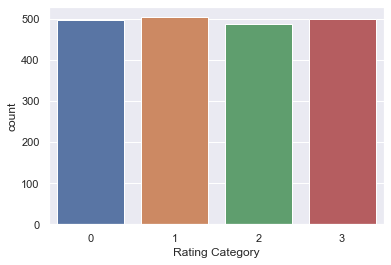

In [12]:
sb.countplot(x = "Rating Category", data = y_train)

### Logistic Regression

Average Accuracy: 0.6119663976447897
Average F1 Score: 0.6088127534397364
Goodness of Fit of Model 	Train Dataset
              precision    recall  f1-score   support

           0      0.605     0.528     0.564       496
           1      0.581     0.665     0.620       504
           2      0.706     0.676     0.690       487
           3      0.710     0.726     0.718       500

    accuracy                          0.649      1987
   macro avg      0.651     0.649     0.648      1987
weighted avg      0.650     0.649     0.648      1987


Goodness of Fit of Model 	Test Dataset
              precision    recall  f1-score   support

           0      0.575     0.491     0.530       171
           1      0.559     0.646     0.599       175
           2      0.656     0.656     0.656       154
           3      0.683     0.675     0.679       163

    accuracy                          0.615       663
   macro avg      0.618     0.617     0.616       663
weighted avg      0.616     0.6

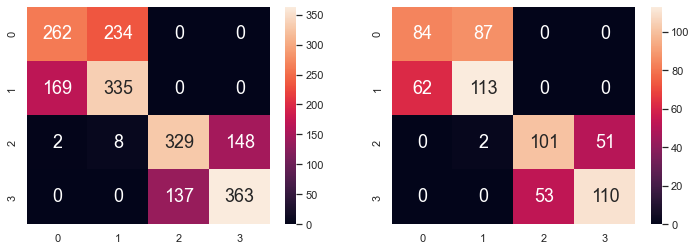

In [14]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter = 500)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_validate(log_reg, X_train, y_train, scoring=["accuracy", "f1_macro"], cv=cv, n_jobs=-1)
print(f"Average Accuracy: {np.mean(scores['test_accuracy'])}")
print(f"Average F1 Score: {np.mean(scores['test_f1_macro'])}")
model_evaluation(log_reg, X_train, X_test, y_train, y_test)



C:\Users\neowe\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


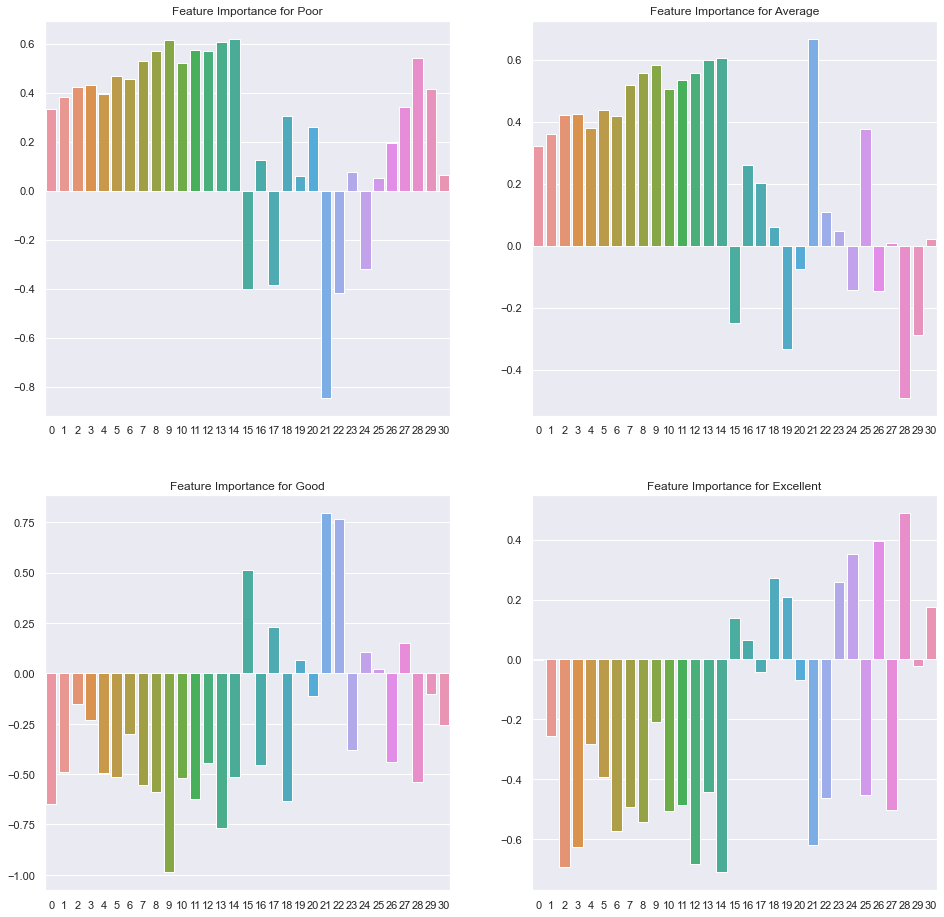

In [19]:
#Feature Importance from Logistic Regression
log_reg.fit(X_train, y_train)
plt.figure(figsize=(16,16))
importance = log_reg.coef_
features = log_reg.feature_names_in_

plt.subplot(221)
sb.barplot(x = [v for v in range(0,31)], y = importance[0])
plt.title("Feature Importance for Poor")

plt.subplot(222)
sb.barplot(x = [v for v in range(0,31)], y = importance[1])
plt.title("Feature Importance for Average")

plt.subplot(223)
sb.barplot(x = [v for v in range(0,31)], y = importance[2])
plt.title("Feature Importance for Good")
plt.subplot(224)
sb.barplot(x = [v for v in range(0,31)], y = importance[3])
plt.title("Feature Importance for Excellent")
plt.show()

### Decision Tree Model

Max Accuracy: 0.6214177978883861, Parameter: 16
Max F1 Score: 0.6218497163137717, Parameter: 16


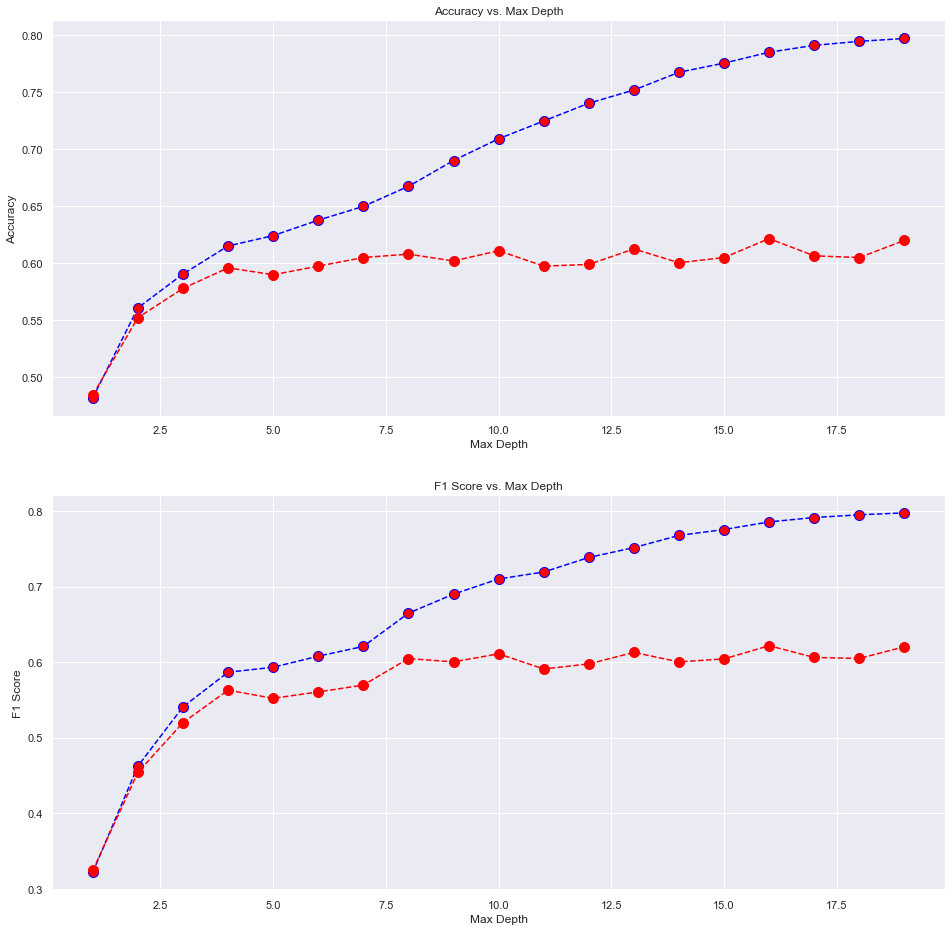

In [20]:
#Decision Tree - Finding Optimal Depth for best Accuracy/F1 Score 
parameter_list = []
accuracy_train_list = []
accuracy_test_list = []
f1_train_list = []
f1_test_list = []
n = 20
for i in range(1, n):
    parameter_list.append(i)
    dectree = DecisionTreeClassifier(max_depth = i)
    accuracy_train, accuracy_test, f1_train, f1_test = model_test(dectree, X_train, X_test, y_train, y_test)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    f1_train_list.append(f1_train)
    f1_test_list.append(f1_test)

get_best_parameter(parameter_list, accuracy_test_list, f1_test_list)
visualize(parameter_list, "Max Depth", 
          accuracy_train_list, accuracy_test_list, 
          f1_train_list, f1_test_list)

Clearly, from the graphs, optimal depth (without severe overfitting) for our decision tree is around **7**

Goodness of Fit of Model 	Train Dataset
              precision    recall  f1-score   support

           0      0.534     0.925     0.677       496
           1      0.742     0.222     0.342       504
           2      0.692     0.813     0.748       487
           3      0.800     0.648     0.716       500

    accuracy                          0.650      1987
   macro avg      0.692     0.652     0.621      1987
weighted avg      0.693     0.650     0.619      1987


Goodness of Fit of Model 	Test Dataset
              precision    recall  f1-score   support

           0      0.528     0.953     0.679       171
           1      0.795     0.177     0.290       175
           2      0.633     0.695     0.663       154
           3      0.692     0.620     0.654       163

    accuracy                          0.606       663
   macro avg      0.662     0.611     0.571       663
weighted avg      0.663     0.606     0.566       663





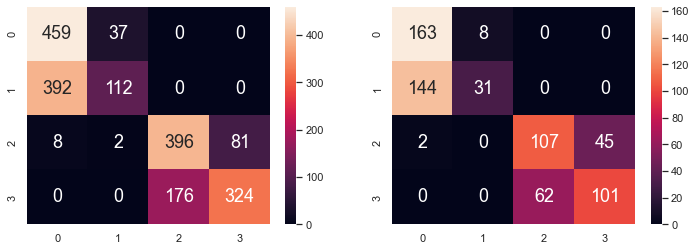

In [21]:
dectree = DecisionTreeClassifier(max_depth = 7)
model_evaluation(dectree, X_train, X_test, y_train, y_test)

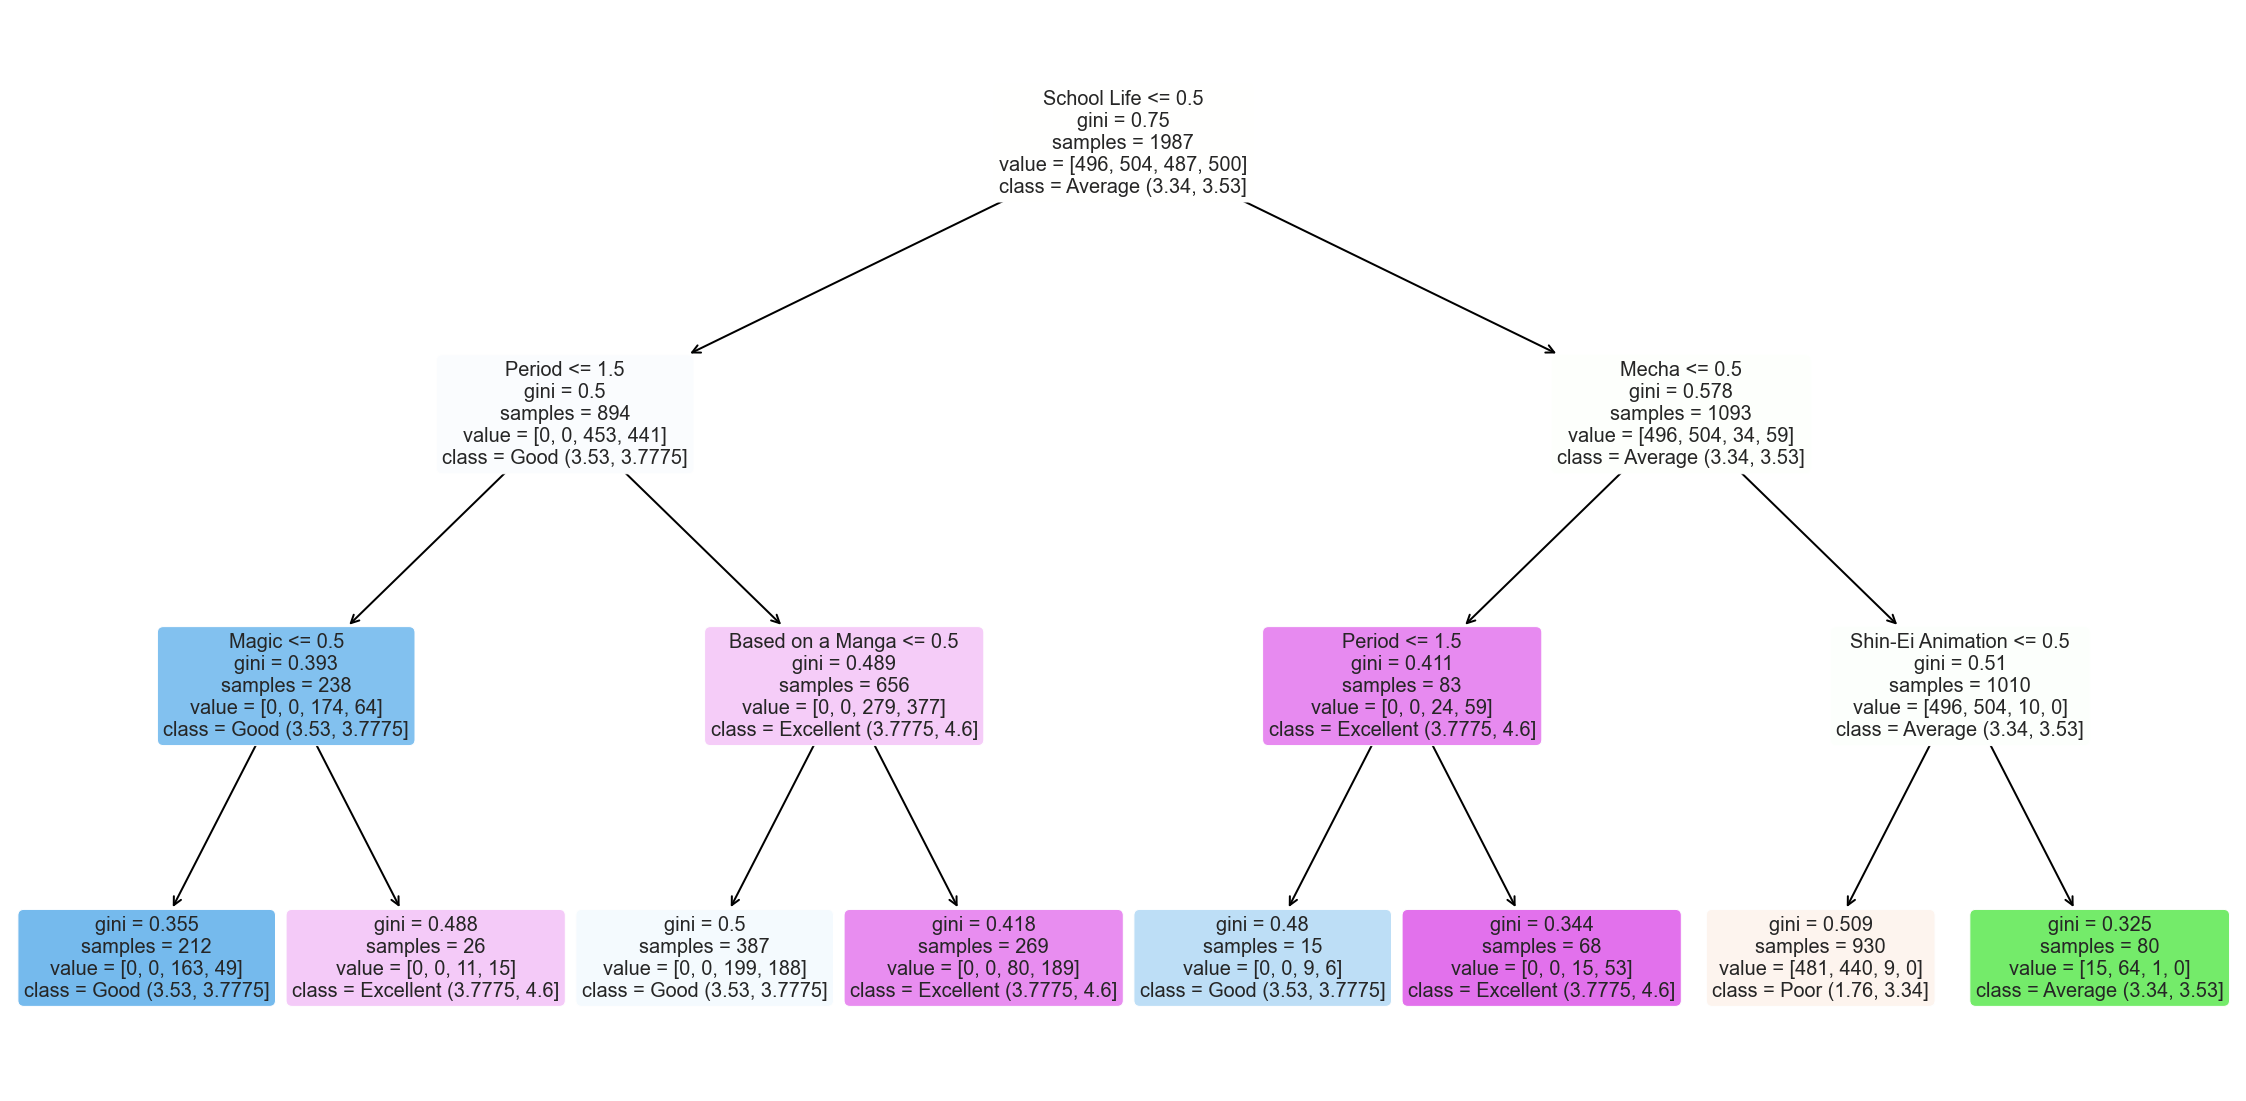

In [22]:
#To visualize what factor is used to decide
dectree = DecisionTreeClassifier(max_depth = 3)
dectree.fit(X_train, y_train)
f = plt.figure(figsize = (40,20))
out = plot_tree(dectree, filled=True, rounded=True,
          feature_names=X_train.columns, 
          class_names=ratings)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(2)

### Random Forest Model

Max Accuracy: 0.6470588235294118, Parameter: 10
Max F1 Score: 0.6484788676677209, Parameter: 10


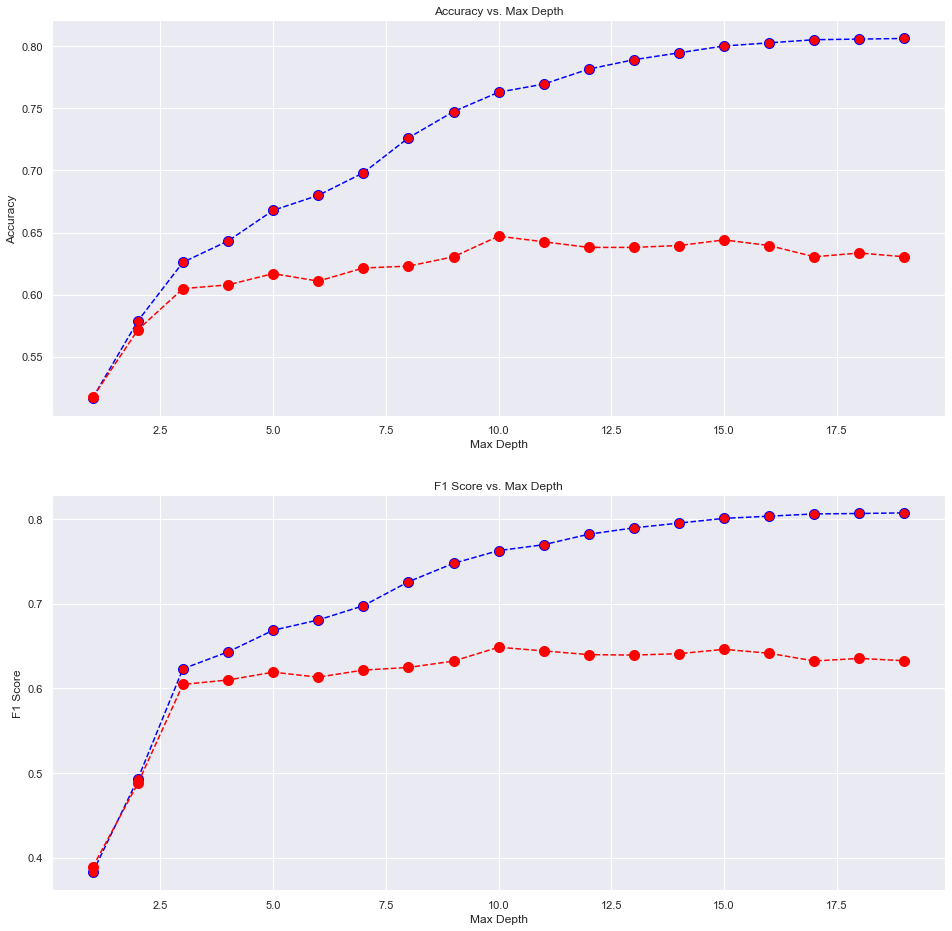

In [23]:
#Random Forest - Finding Optimal Depth for best Accuracy/F1 Score 
parameter_list = []
accuracy_train_list = []
accuracy_test_list = []
f1_train_list = []
f1_test_list = []
d = 20
for i in range(1, d, 1):
    parameter_list.append(i)
    rforest = RandomForestClassifier(n_estimators = 400,  # n_estimators denote number of trees
                                     max_depth = i, random_state=5)       # set the maximum depth of each tree    
    accuracy_train, accuracy_test, f1_train, f1_test = model_test(rforest, X_train, X_test, y_train, y_test)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    f1_train_list.append(f1_train)
    f1_test_list.append(f1_test)
get_best_parameter(parameter_list, accuracy_test_list, f1_test_list)  
visualize(parameter_list, "Max Depth", accuracy_train_list, accuracy_test_list,f1_train_list,f1_test_list)

From the above graph, the optimal depth (without severe overfitting) is 5

Goodness of Fit of Model 	Train Dataset
              precision    recall  f1-score   support

           0      0.594     0.599     0.596       496
           1      0.596     0.603     0.600       504
           2      0.740     0.715     0.727       487
           3      0.746     0.756     0.751       500

    accuracy                          0.668      1987
   macro avg      0.669     0.668     0.669      1987
weighted avg      0.669     0.668     0.668      1987


Goodness of Fit of Model 	Test Dataset
              precision    recall  f1-score   support

           0      0.557     0.567     0.562       171
           1      0.563     0.560     0.562       175
           2      0.676     0.636     0.656       154
           3      0.682     0.712     0.697       163

    accuracy                          0.617       663
   macro avg      0.620     0.619     0.619       663
weighted avg      0.617     0.617     0.617       663





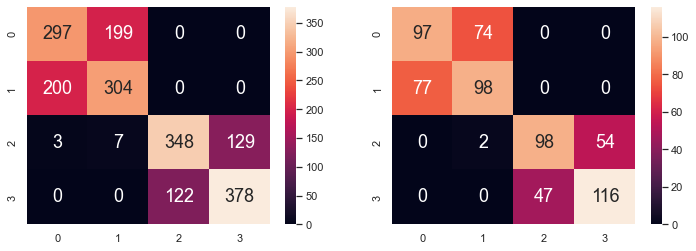

In [24]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 400,  # n_estimators denote number of trees
                                 max_depth = 5, random_state=5)       # set the maximum depth of each tree
model_evaluation(rforest, X_train, X_test, y_train, y_test)

<Figure size 1440x2880 with 0 Axes>

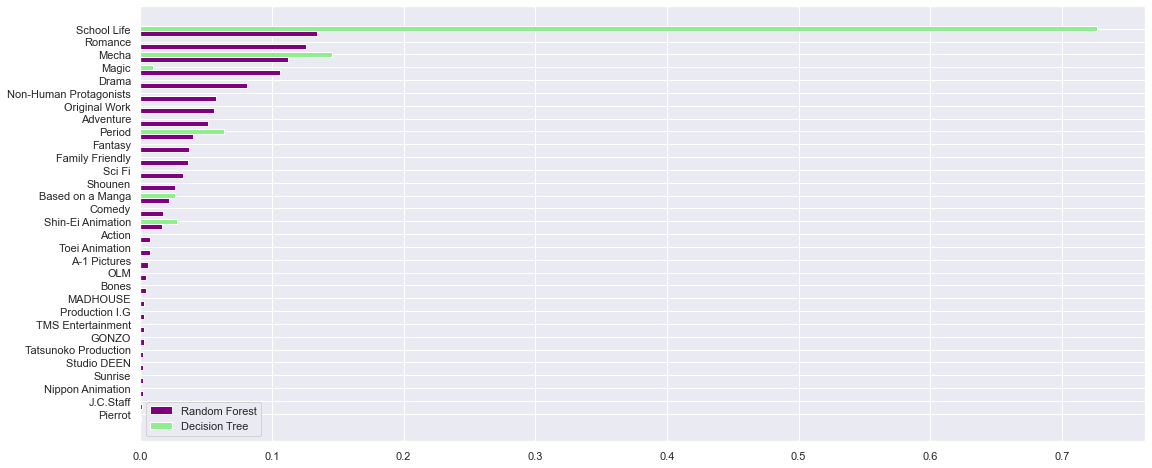

In [25]:
plt.figure(figsize = (20,40))
feature_importance=pd.DataFrame({
    'rfc':rforest.feature_importances_,
    'dt':dectree.feature_importances_
},index=predictors)

feature_importance.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(18,8))
rfc_feature=ax.barh(index,feature_importance['rfc'],0.4,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.4,feature_importance['dt'],0.4,color='lightgreen',label='Decision Tree')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)

ax.legend()
plt.show()

### K Nearest Neighbours Model

Max Accuracy: 0.6319758672699849, Parameter: 22
Max F1 Score: 0.633151782544672, Parameter: 22


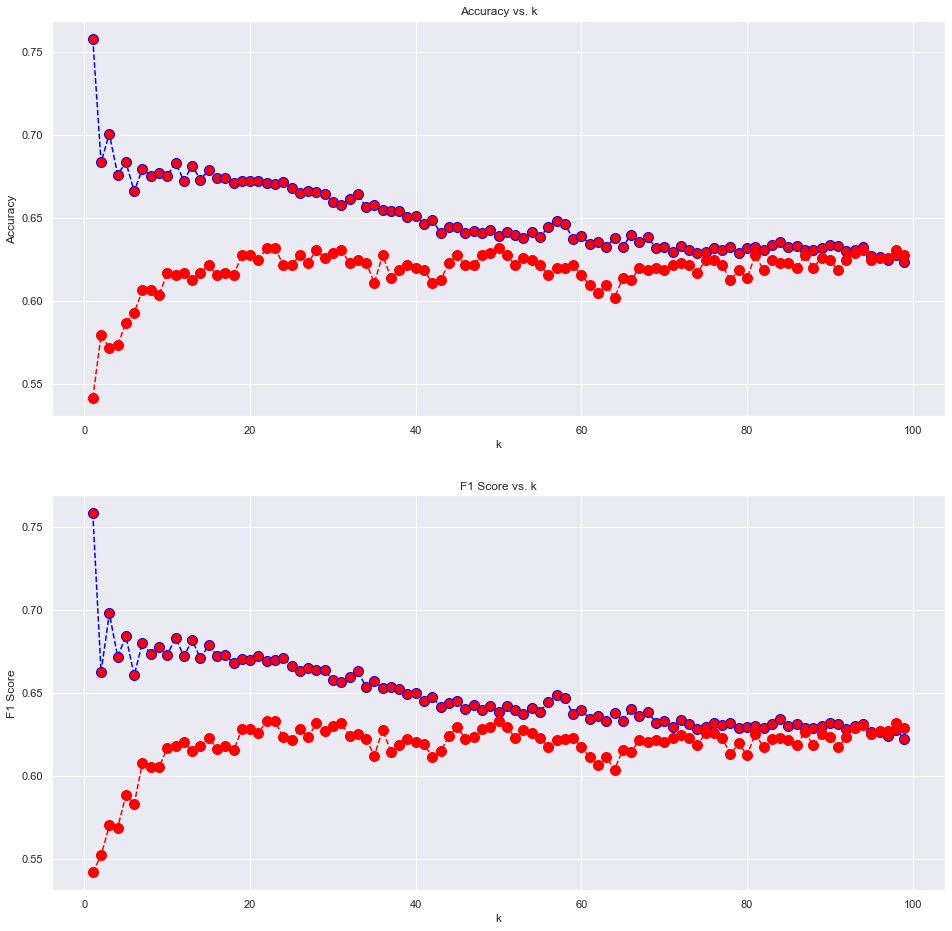

In [26]:
#K Nearest Neighbour - Finding Optimal k for best Accuracy/F1 Score 
parameter_list = []
accuracy_train_list = []
accuracy_test_list = []
f1_train_list = []
f1_test_list = []
n = 100
for k in range(1, n):
    parameter_list.append(k)
    neigh = KNeighborsClassifier(n_neighbors = k)
    accuracy_train, accuracy_test, f1_train, f1_test = model_test(neigh, X_train, X_test, y_train, y_test)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)
    f1_train_list.append(f1_train)
    f1_test_list.append(f1_test)

get_best_parameter(parameter_list, accuracy_test_list, f1_test_list)
visualize(parameter_list, "k", 
          accuracy_train_list, accuracy_test_list, 
          f1_train_list, f1_test_list)

From the above graph, the optimal k (without severe overfitting) is 50

Goodness of Fit of Model 	Train Dataset
              precision    recall  f1-score   support

           0      0.587     0.671     0.627       496
           1      0.619     0.544     0.579       504
           2      0.660     0.706     0.683       487
           3      0.708     0.646     0.676       500

    accuracy                          0.641      1987
   macro avg      0.644     0.642     0.641      1987
weighted avg      0.644     0.641     0.640      1987


Goodness of Fit of Model 	Test Dataset
              precision    recall  f1-score   support

           0      0.576     0.643     0.608       171
           1      0.599     0.537     0.566       175
           2      0.644     0.682     0.662       154
           3      0.691     0.644     0.667       163

    accuracy                          0.624       663
   macro avg      0.627     0.627     0.626       663
weighted avg      0.626     0.624     0.624       663





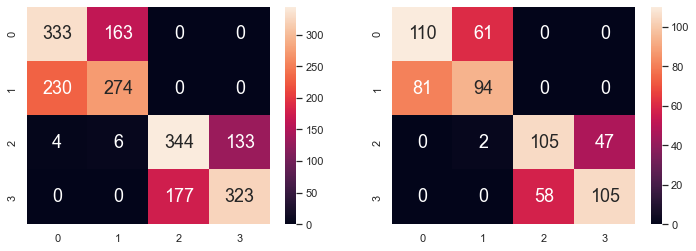

In [27]:
neigh = KNeighborsClassifier(n_neighbors=54)
model_evaluation(neigh, X_train, X_test, y_train, y_test)

### MLP Classifier (Neural Network)

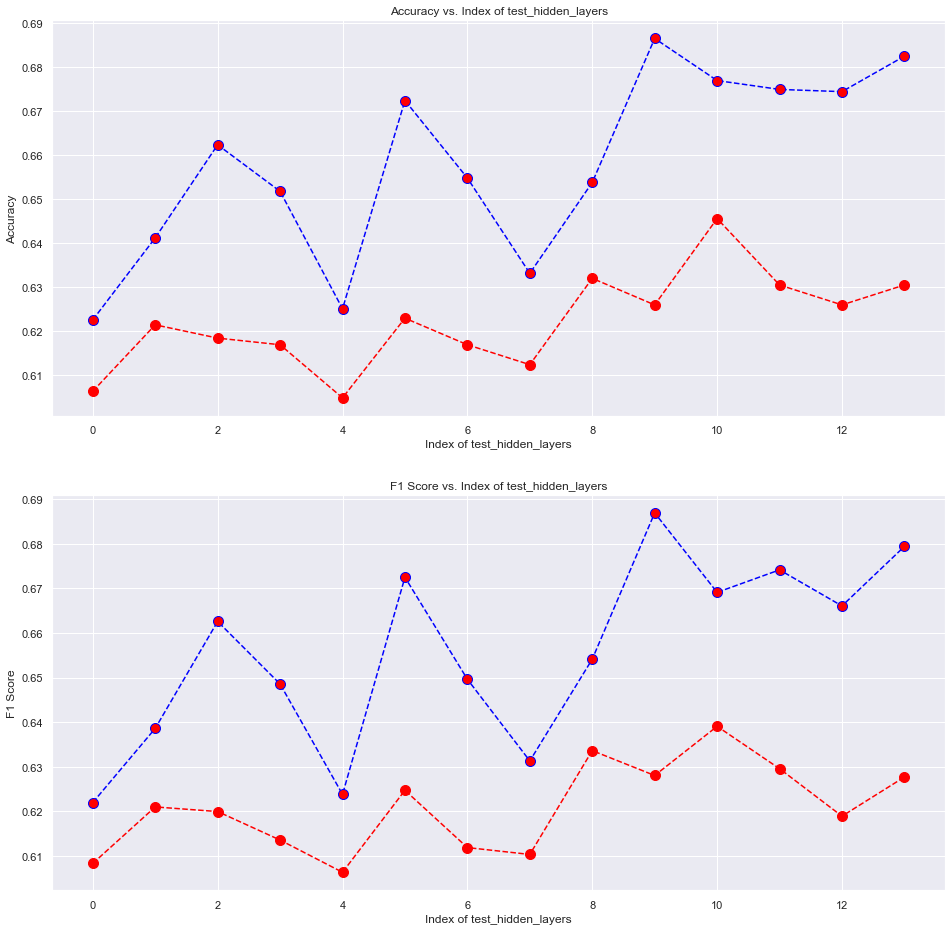

In [28]:
#Finding best number of neural layers & number of neurons for each layer
parameter_list = [(16), (32), (64), (128), 
 (32, 16), (64, 16), (128, 16), (64, 32), (128, 32), (128, 64), 
 (128, 64, 32), (128, 64, 16), (128, 32, 16), 
 (128, 64, 32, 16)]
accuracy_train_list = np.zeros(len(parameter_list))
accuracy_test_list = np.zeros(len(parameter_list))
f1_train_list = np.zeros(len(parameter_list))
f1_test_list = np.zeros(len(parameter_list))

iteration = 20
for i in range(iteration):
    for j in range(len(parameter_list)):
        mlp = MLPClassifier(hidden_layer_sizes=parameter_list[j], 
                        activation='relu', 
                        solver='adam', 
                        max_iter=500, 
                        early_stopping = True, #To prevent overfitting
                        validation_fraction = 0.2, random_state = 1) 
        accuracy_train, accuracy_test, f1_train, f1_test = model_test(mlp, X_train, X_test, y_train, y_test)
        accuracy_train_list[j] += accuracy_train
        accuracy_test_list[j] += accuracy_test
        f1_train_list[j] += f1_train
        f1_test_list[j] += f1_test

#Finding average performance of neural network
accuracy_train_list = accuracy_train_list/iteration
accuracy_test_list = accuracy_test_list/iteration
f1_train_list = f1_train_list/iteration 
f1_test_list = f1_test_list/iteration

visualize(range(0, len(parameter_list)), "Index of test_hidden_layers", accuracy_train_list, accuracy_test_list, f1_train_list, f1_test_list)

In [29]:
parameter_list[9]

(128, 64)

Goodness of Fit of Model 	Train Dataset
              precision    recall  f1-score   support

           0      0.577     0.821     0.678       496
           1      0.695     0.421     0.524       504
           2      0.770     0.661     0.712       487
           3      0.723     0.808     0.763       500

    accuracy                          0.677      1987
   macro avg      0.691     0.678     0.669      1987
weighted avg      0.691     0.677     0.669      1987


Goodness of Fit of Model 	Test Dataset
              precision    recall  f1-score   support

           0      0.553     0.789     0.651       171
           1      0.654     0.389     0.487       175
           2      0.735     0.630     0.678       154
           3      0.699     0.785     0.740       163

    accuracy                          0.646       663
   macro avg      0.660     0.648     0.639       663
weighted avg      0.658     0.646     0.636       663





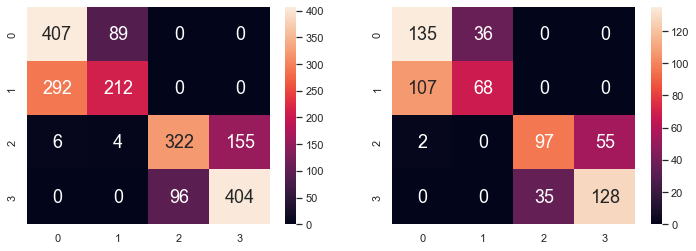

In [30]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), 
                    activation='relu', 
                    solver='adam', 
                    max_iter=500, 
                    early_stopping = True, #To prevent overfitting
                    validation_fraction = 0.2, random_state = 1) 


model_evaluation(mlp, X_train, X_test, y_train, y_test)